In [47]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import numpy as np
import mapclassify as mc
housetwitter = pd.read_csv('housetwitter1.csv')

In [3]:
# Load SA3 shape files
# Statistical Area Level 3 (SA3) ASGS Ed 2016 Digital Boundaries in MapInfo Interchange Format
import geopandas as gpd
income = pd.read_csv('aurin_data/2014-2018 mean_income.csv', index_col = 'Code')
sa3 = gpd.read_file('https://www.abs.gov.au/AUSSTATS/subscriber.nsf/log?openagent&1270055001_sa3_2016_aust_midmif.zip&1270.0.55.001&Data%20Cubes&31ACD8D865DE06E5CA257FED00144DEE&0&July%202016&12.07.2016&Latest')
sa3['SA3_CODE_2016'] = sa3['SA3_CODE_2016'].astype(int)
sa3 = sa3.set_index('SA3_CODE_2016')
sa3_mel = sa3.loc[income.index, ['geometry']]

In [54]:
#get the coordinates of tweetes
import re
cord = []
for i in range(len(housetwitter)):
    cord1 = float(re.findall("\d+\.\d+", housetwitter['coordinates'][i])[0])
    cord2 = float(re.findall("-\d+\.\d+", housetwitter['coordinates'][0])[0])
    cord.append((cord1, cord2))
housetwitter['coordinates'] = cord

In [55]:
# assign geo location
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

geo_code = []
for i in range(len(housetwitter)):
    point = Point(cord[i][0], cord[i][1])
    find = False
    for code, row in sa3_mel.iterrows():
    #for poly in sa3_mel['geometry']:
        poly = row['geometry']
        if poly.contains(point) == True:
            geo_code.append(code)
            find = True
            break
    if find == False:
        geo_code.append('Not found')

In [56]:
housetwitter['geo_code'] = geo_code
housetwitter.head()

,text,tidy_text,polarity_score_vader,polarity_score_textblob,label_vader,label_textblob,coordinates,geo_code
0,Regram from @kahseong of this mornings special...,Regram from of this mornings special: Poached ...,"(0.0, 0.162)",0.357143,positive,positive,"(144.95916008, -37.80278685)",20604
1,Listening to @GreenTravelGuy talk to a packed...,Listening to talk to a packed house on respons...,"(0.0, 0.187)",0.200000,positive,positive,"(144.96186057, -37.80278685)",20604
2,#oxley under construction.... beginning to tak...,#oxley under construction.... beginning to tak...,"(0.0, 0.0)",0.000000,neutral,neutral,"(144.98644128, -37.80278685)",20607
3,when i move into my new house im gonna maratho...,when i move into my new house im gonna maratho...,"(0.099, 0.16)",0.202841,positive,positive,"(144.9854037, -37.80278685)",20607
4,Someone come play uno at my school or at least...,Someone come play uno at my school or at least...,"(0.0, 0.227)",-0.300000,positive,negative,"(144.89813344, -37.80278685)",21303


In [9]:
#housetwitter['label_vader'].value_counts().plot(kind='bar');

In [12]:
#housetwitter['label_textblob'].value_counts().plot(kind='bar');

## Semtiment by SA3

In [67]:
from collections import Counter
import numpy as np
def sentiment_percentage(labels):
    counts = Counter(labels)
    neg = counts['negative']
    pos = counts['positive']
    neu = counts['neutral']
    s = len(labels)
    return np.round(np.array([pos, neu, neg])/s*100, 2)

In [68]:
grouped_SA3 = pd.DataFrame(housetwitter.groupby('geo_code')['label_textblob'].apply(list))
#grouped_SA3 = grouped_SA3[grouped_SA3.index != "Not found"]
percentages = []
for code, row in grouped_SA3.iterrows():
    percentages.append(sentiment_percentage(row['label_textblob']))
grouped_SA3['pos_pctg'] = [p[0] for p in percentages]
grouped_SA3['neu_pctg'] = [p[1] for p in percentages]
grouped_SA3['neg_pctg'] = [p[2] for p in percentages]
grouped_SA3


,label_textblob,pos_pctg,neu_pctg,neg_pctg
geo_code,,,,
20102,"[negative, positive, neutral, neutral, positiv...",85.00,0.0,15.00
20604,"[positive, positive, neutral, positive, positi...",75.19,0.0,24.81
20607,"[neutral, positive, neutral, positive, neutral...",76.00,0.0,24.00
20701,"[positive, neutral, positive, negative, positi...",76.10,0.0,23.90
20703,"[negative, positive, positive, positive, posit...",70.06,0.0,29.94
21102,"[neutral, negative, negative, positive, positi...",76.65,0.0,23.35
21103,"[positive, positive, neutral, neutral, negativ...",71.24,0.0,28.76
21104,"[positive, neutral, positive, neutral, negativ...",75.00,0.0,25.00
21105,"[positive, positive, positive, positive, posit...",67.56,0.0,32.44


In [90]:
full_data = sa3_mel.merge(grouped_SA3, left_index=True, right_index=True, how='left').fillna(0)
full_data.head()

,geometry,label_textblob,pos_pctg,neu_pctg,neg_pctg
Code,,,,,
20102,"POLYGON ((143.67535 -37.32521, 143.66604 -37.3...","[negative, positive, neutral, neutral, positiv...",85.0,0.0,15.0
20202,"POLYGON ((143.97372 -37.03421, 143.97242 -37.0...",0,0.0,0.0,0.0
20302,"POLYGON ((144.32819 -37.84451, 144.32835 -37.8...",0,0.0,0.0,0.0
20303,"MULTIPOLYGON (((144.63872 -38.26746, 144.63862...",0,0.0,0.0,0.0
20401,"POLYGON ((146.11110 -36.85860, 146.12166 -36.8...",0,0.0,0.0,0.0


/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


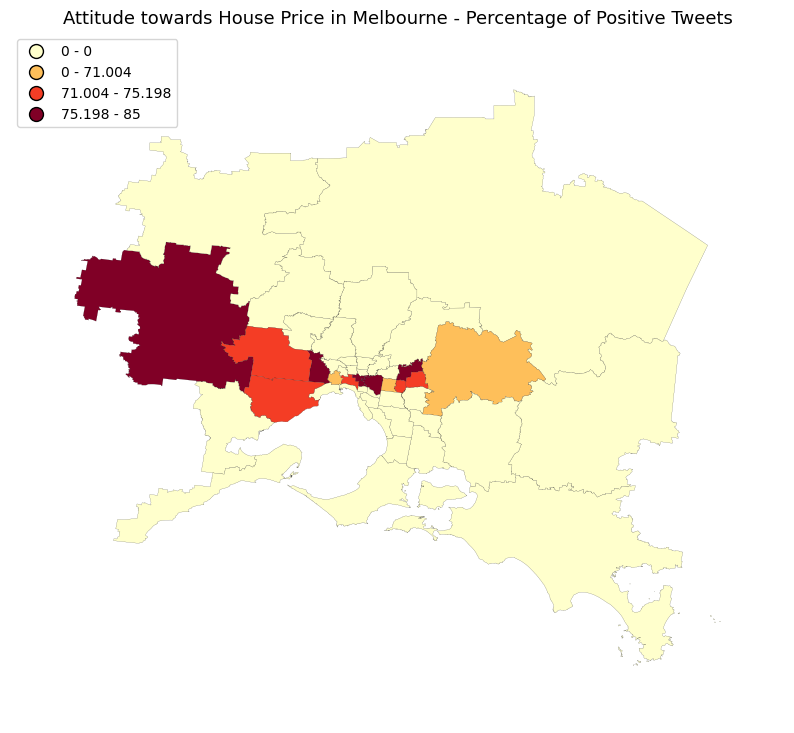

In [91]:
# change year and indicator to view different Choropleth
year = '2015'
indicator = 'Property Price Growth Rate' # ['Property Price Growth Rate', 'Median Property Price', 'Mean Income', 'Population Density', 'Total Population']
hue = 'pos_pctg' # 'pos_pctg', 'neu_pctg', 'neg_pctg'

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
scheme = mc.Quantiles(full_data[hue], k=10) # Set up the color sheme
#gplt.polyplot(sa3_mel, facecolor="lightgrey");
gplt.choropleth(full_data, 
    hue=hue,
    linewidth=.1,
    scheme=scheme, cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    ax=ax
);
ax.set_title('Attitude towards House Price in Melbourne - Percentage of Positive Tweets', fontsize=13);

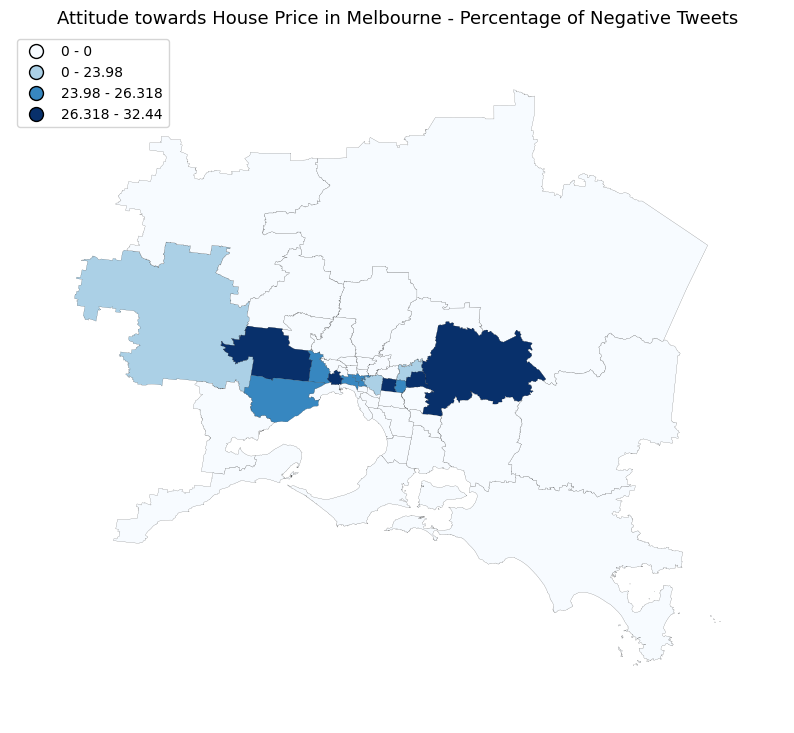

In [92]:
# change year and indicator to view different Choropleth
hue = 'neg_pctg' # 'pos_pctg', 'neu_pctg', 'neg_pctg'

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
scheme = mc.Quantiles(full_data[hue], k=10) # Set up the color sheme
#gplt.polyplot(sa3_mel, facecolor="lightgrey");
gplt.choropleth(full_data, 
    hue=hue,
    linewidth=.1,
    scheme=scheme, cmap='Blues',
    legend=True,
    edgecolor='black',
    ax=ax
);
ax.set_title('Attitude towards House Price in Melbourne - Percentage of Negative Tweets', fontsize=13);